In [1]:
# Import necessary libraries
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Set seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
# Check if GPU is available and set up memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"TensorFlow is using GPU: {tf.config.list_physical_devices('GPU')}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. TensorFlow will use the CPU.")

No GPU detected. TensorFlow will use the CPU.


In [4]:
img_height, img_width = 224, 224
batch_size = 30

# Load training, validation and test dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"harumanis-leaves/train",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    seed=seed_value
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    r"harumanis-leaves/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    seed=seed_value
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    r"harumanis-leaves/test",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    seed=seed_value
)

Found 984 files belonging to 3 classes.
Found 212 files belonging to 3 classes.
Found 209 files belonging to 3 classes.


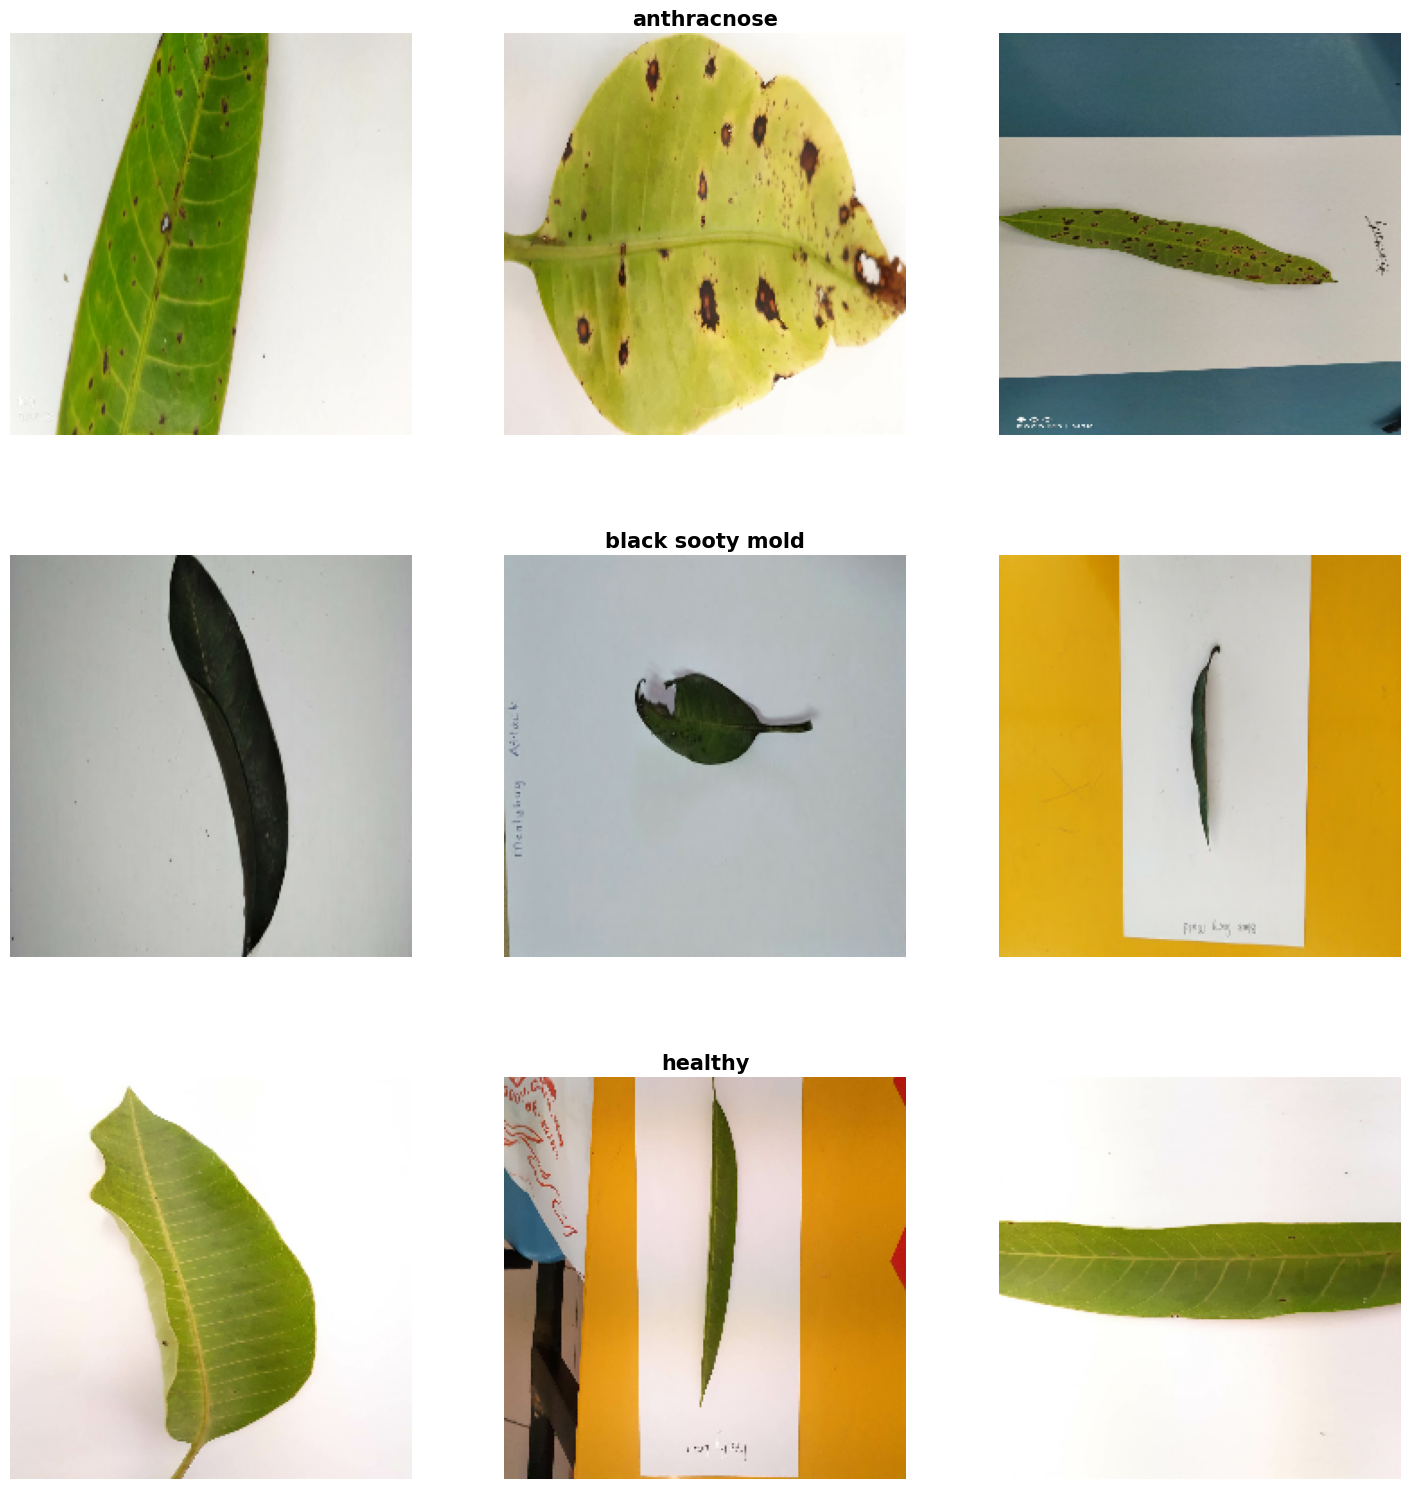

In [5]:
class_names = ["anthracnose", "black sooty mold", "healthy"]

# Prepare a figure
plt.figure(figsize=(15, 15))

# Counter to track images per class
class_counters = {class_name: 0 for class_name in class_names}

# Loop through the dataset and display images
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        if class_counters[class_name] < 3:  # Display only 3 images per class
            idx = class_names.index(class_name) * 3 + class_counters[class_name] + 1
            plt.subplot(3, 3, idx)
            plt.imshow(img.numpy().astype("uint8"))
            if class_counters[class_name] == 1:  # Center title
                plt.title(class_name, fontsize=15, fontweight='bold')
            plt.axis("off")
            class_counters[class_name] += 1
        if all(count == 3 for count in class_counters.values()):  # Done if all classes have 3 images
            break
    if all(count == 3 for count in class_counters.values()):
        break

plt.tight_layout()
plt.subplots_adjust(hspace=0.3) 
plt.show()

In [6]:
model = tf.keras.Sequential(
    [
        # Normalize pixel values to the range [0, 1]
        tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

        # First convolutional layer followed by max-pooling
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        # Second convolutional layer followed by max-pooling
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        # Third convolutional layer followed by max-pooling
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        # Flatten layer to convert 2D feature maps into 1D feature vectors
        tf.keras.layers.Flatten(),

        # Fully connected layer with 128 units and ReLU activation
        tf.keras.layers.Dense(128, activation="relu"),

        # Dropout layer with 30% drop
        tf.keras.layers.Dropout(0.3),
        
        # Output layer with 3 neurons (one for each class) and Softmax activation
        tf.keras.layers.Dense(3, activation="softmax")
    ]
)

# Compile the model
model.compile(
    optimizer='adam',  # Optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Loss function
    metrics=['accuracy']  # Evaluation metric
)

# Print a summary of the model structure
model.summary()

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,788,803 (10.64 MB)

 Trainable params: 2,788,803 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch after stopping
)

In [8]:
# Model training with EarlyStopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.5063 - loss: 1.0148 - val_accuracy: 0.8160 - val_loss: 0.5357
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.8360 - loss: 0.3852 - val_accuracy: 0.8821 - val_loss: 0.4176
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.8998 - loss: 0.2178 - val_accuracy: 0.8962 - val_loss: 0.3858
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - accuracy: 0.9360 - loss: 0.1475 - val_accuracy: 0.8726 - val_loss: 0.5078
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9564 - loss: 0.1140 - val_accuracy: 0.8349 - val_loss: 0.5282
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.9481 - loss: 0.1150 - val_accuracy: 0.8774 - val_loss: 0.4845
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.9734 - loss: 0.0806 - val_accuracy: 0.9245 - val_loss: 0.3315
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.9715 - loss: 0.0714 - val_accuracy: 0

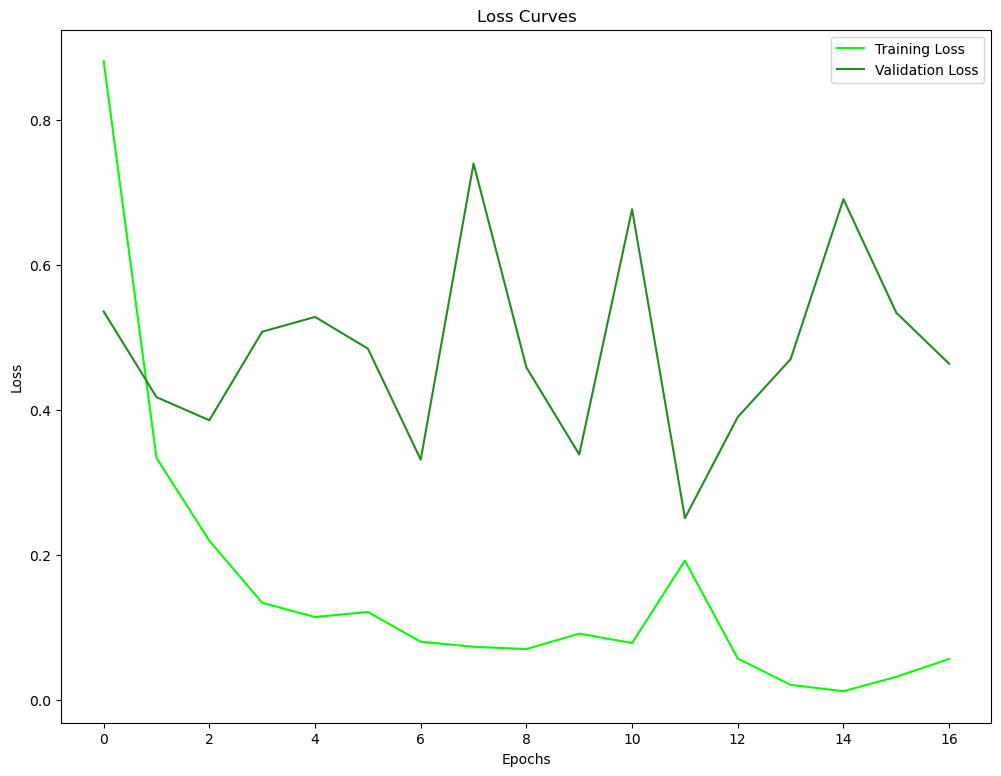

In [9]:
# Plot loss curves
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'], label='Training Loss', color="lime")
plt.plot(history.history['val_loss'], label='Validation Loss', color="forestgreen")
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

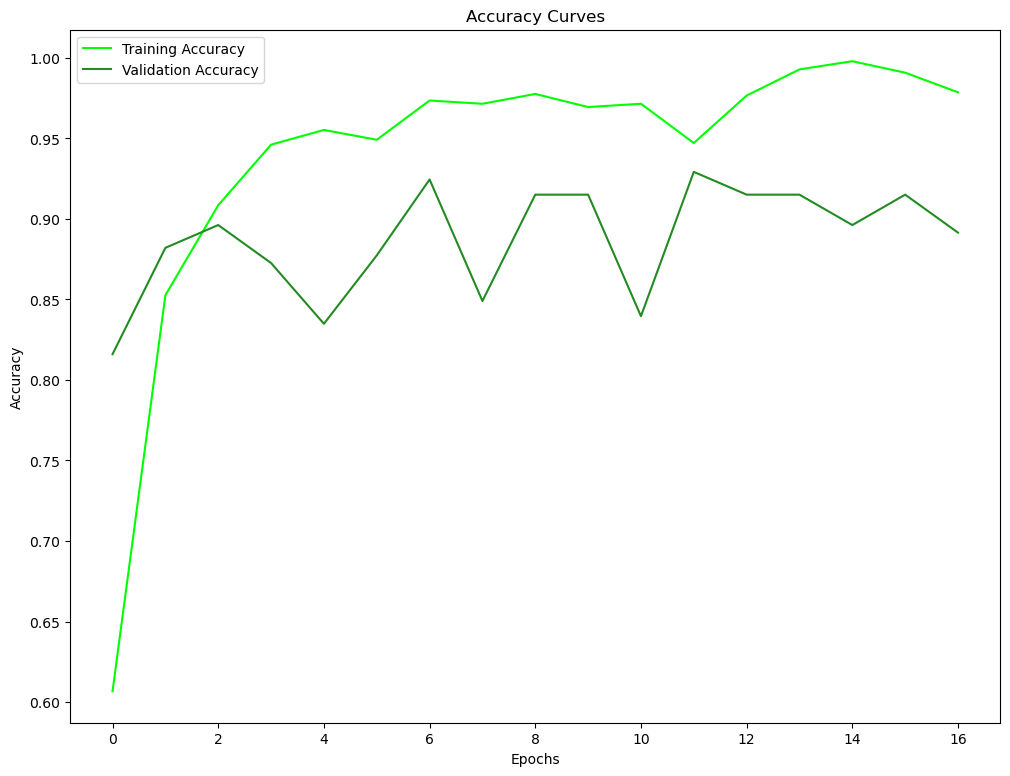

In [10]:
# Plot accuracy curves
plt.figure(figsize=(12, 9))
plt.plot(history.history['accuracy'], label='Training Accuracy', color="lime")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color="forestgreen")
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Generate predictions
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the validation dataset
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Classification Report:
                  precision    recall  f1-score   support

     anthracnose       0.91      0.94      0.93        79
black sooty mold       0.94      0.95      0.94        99
         healthy       0.94      0.85      0.89        34

        accuracy                           0.93       212
       macro avg       0.93      0.91      0.92       212
    weighted avg       0.93      0.93      0.93       212



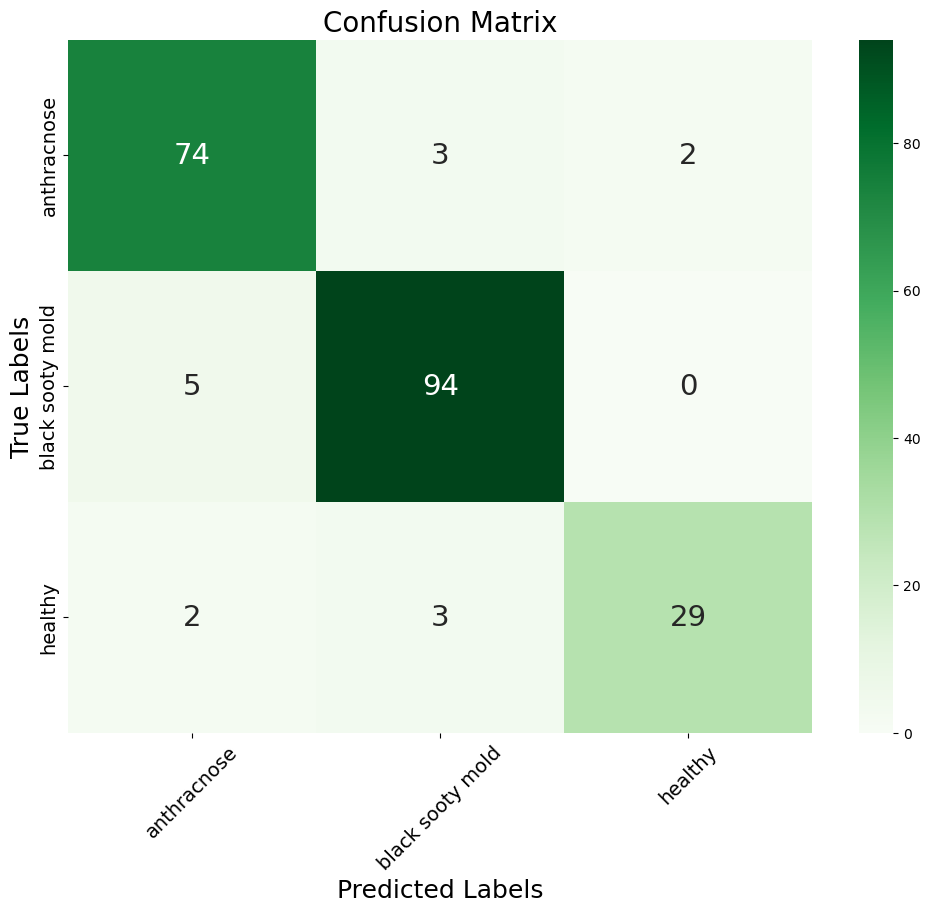

In [12]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 21})  # Increase annotation font size

# Increase label and title font sizes
plt.xlabel("Predicted Labels", fontsize=18)
plt.ylabel("True Labels", fontsize=18)
plt.title("Confusion Matrix", fontsize=20)

# Adjust tick labels' font size
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.show()


In [13]:
# Evaluate on test dataset
model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9023 - loss: 0.4145


[0.5611476898193359, 0.8612440228462219]

In [14]:
for images, labels in test_ds.take(1):
  classifications = model(images)   # Get model predictions (classifications) for the batch of images
  print(classifications)   # Print raw classification outputs (logits or probabilities)

tf.Tensor(
[[9.99463022e-01 4.40195436e-04 9.66923908e-05]
 [7.67074645e-01 1.71831012e-01 6.10943101e-02]
 [9.61607814e-01 1.80070335e-03 3.65915596e-02]
 [2.74121501e-02 9.72587407e-01 5.09997676e-07]
 [9.98802662e-01 5.97218459e-04 6.00130530e-04]
 [9.99729216e-01 2.07788922e-04 6.28946582e-05]
 [6.05005724e-03 9.93950009e-01 1.45901835e-09]
 [9.86114264e-01 1.18187545e-02 2.06697499e-03]
 [7.56021915e-03 2.85319626e-01 7.07120180e-01]
 [2.78098702e-01 9.11172107e-02 6.30784094e-01]
 [1.82522100e-03 9.98174787e-01 2.35703479e-09]
 [9.98756051e-01 1.23411091e-03 9.88947613e-06]
 [8.37977687e-09 1.00000000e+00 2.78496112e-13]
 [9.96217191e-01 6.29032671e-04 3.15369293e-03]
 [1.30632572e-04 9.99869347e-01 5.69338976e-09]
 [9.31235433e-01 2.80601010e-02 4.07044329e-02]
 [9.99997258e-01 1.40448551e-08 2.74719946e-06]
 [7.04732686e-02 9.29523349e-01 3.36968833e-06]
 [2.36634105e-01 3.65198217e-02 7.26846039e-01]
 [1.57530725e-01 8.42469275e-01 6.02519767e-09]
 [1.86604038e-01 8.12962413e-

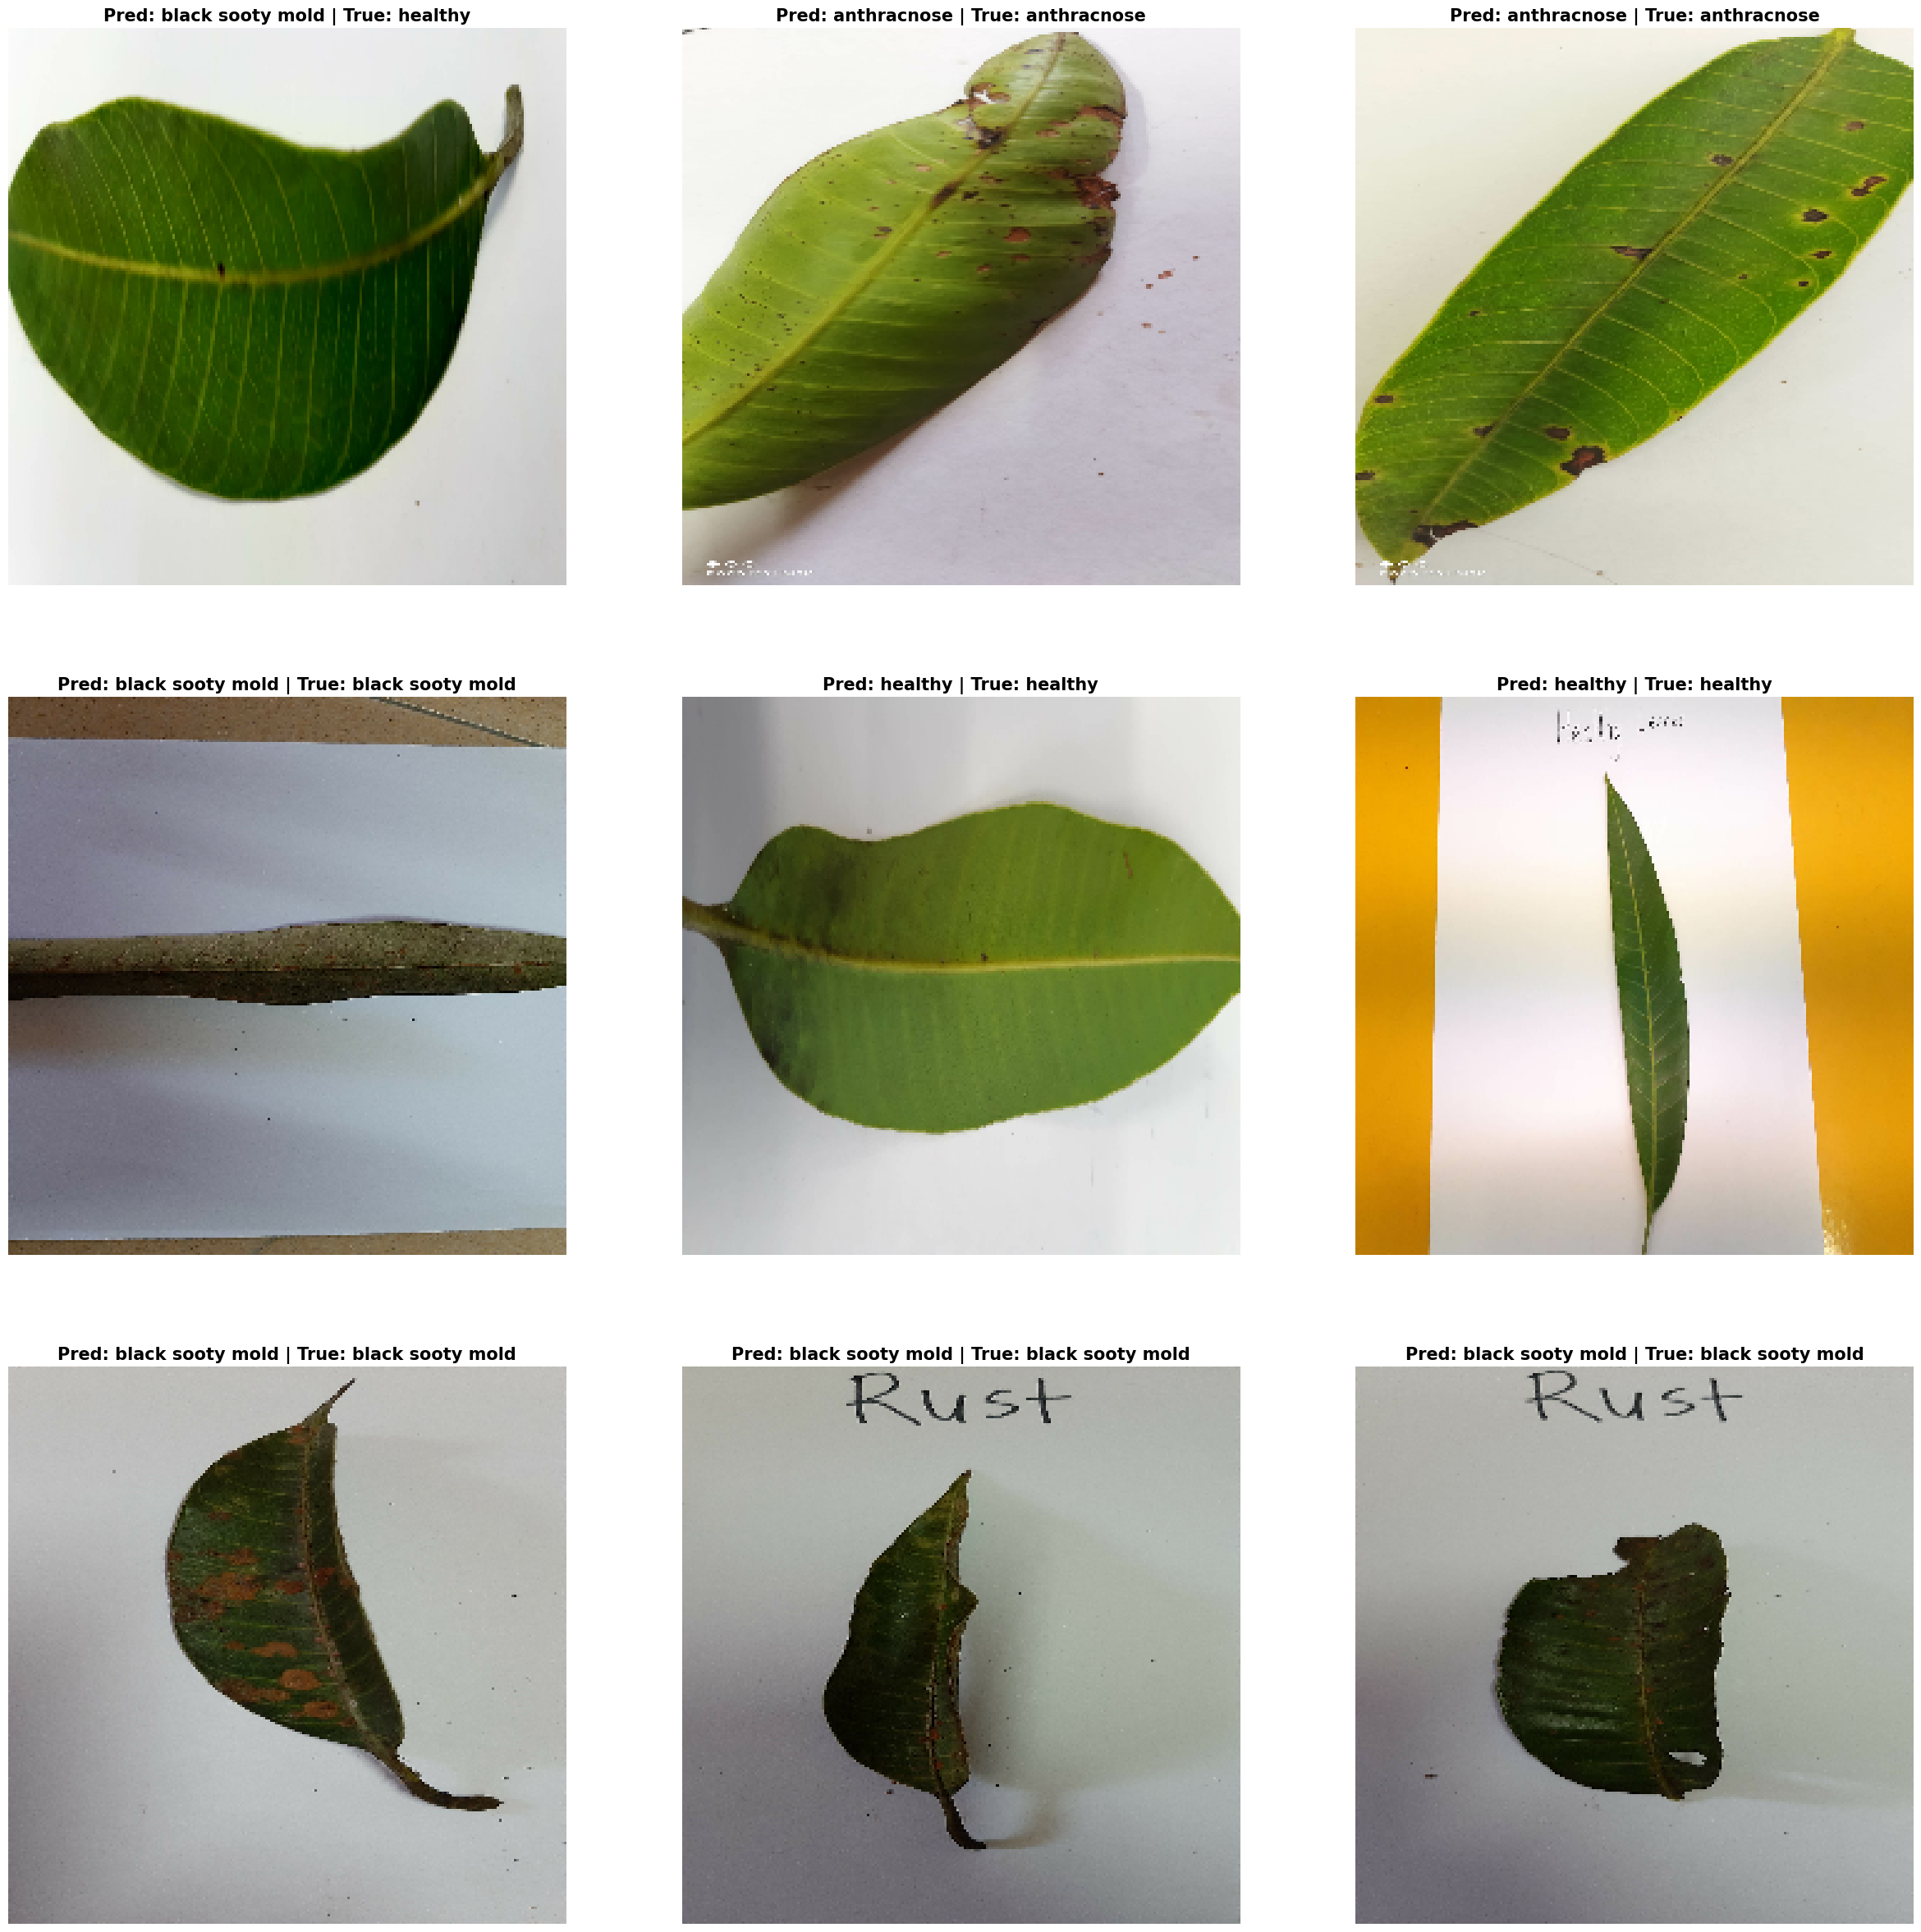

In [15]:
# Randomize indices for images and labels
random_indices = np.random.choice(len(images), 9, replace=False)

plt.figure(figsize=(30, 30))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].numpy().astype("uint8"))
    index = np.argmax(classifications[idx])   # Get the predicted class index (with the highest probability)
    plt.title(
        f"Pred: {class_names[index]} | True: {class_names[labels[idx]]}",
        fontsize=15,
        fontweight="bold"
    )
    plt.axis("off")

plt.show()

In [16]:
# Save the trained model in .keras format
model.save("harumanis-model.keras")

# Convert trained Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("harumanis-model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\adzim\AppData\Local\Temp\tmppwlcd42x\assets


INFO:tensorflow:Assets written to: C:\Users\adzim\AppData\Local\Temp\tmppwlcd42x\assets


Saved artifact at 'C:\Users\adzim\AppData\Local\Temp\tmppwlcd42x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2288986427792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986429904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986429712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986430480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986430288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986430864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986429136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986431632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986432016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2288986432976: TensorSpec(shape=(), dtype=tf.resource, name=None)
